## Desenvolvimento do Data Warehouse

O desenvolvimento do Data Warehouse teve como objetivo demonstrar uma abordagem estruturada para análise de dados da Northwind Traders. Para este exercício, optou-se por ferramentas que permitissem simular um ambiente analítico empresarial com foco na simplicidade de implementação.

### Tecnologia

A escolha do DuckDB como solução de armazenamento e processamento, combinado com dbt (data build tool) para transformações, baseou-se em:
- Facilidade de implementação para demonstração do exercício
- Capacidade de simular um ambiente analítico empresarial
- Simplicidade na ingestão dos dados dos arquivos CSV fornecidos
- Possibilidade de demonstrar conhecimentos em SQL e modelagem dimensional

Em um ambiente empresarial real, outras soluções como Snowflake, BigQuery ou Redshift seriam consideradas, dependendo de fatores como volume de dados, requisitos de segurança e orçamento disponível.

### Arquitetura

A estrutura do Data Warehouse seguiu práticas comuns do mercado, organizando os dados em duas camadas:

1. **Staging (stg)**
   - Padronização inicial dos dados
   - Conversão e validação de tipos
   - Preparação para modelagem dimensional

2. **Data Warehouse (dw)**
   - Modelo dimensional em estrela
   - Tabelas de fatos e dimensões
   - Métricas calculadas

### Modelo Dimensional

O modelo dimensional foi projetado para demonstrar boas práticas de modelagem:

#### Dimensões
- **dim_customers**: Perfil dos clientes e métricas de pedidos
- **dim_products**: Produtos, categorias e indicadores de estoque
- **dim_employees**: Vendedores e territórios de atuação
- **dim_dates**: Calendário analítico
- **dim_geography**: Consolidação geográfica

#### Fatos
- **fct_orders**: Registros de pedidos e métricas de entrega
- **fct_order_details**: Itens vendidos, preços e descontos

### Resultados da Implementação

1. **Dados**
   - Padronização de formatos
   - Implementação de testes
   - Documentação das transformações

2. **Análise**
   - Estruturação das consultas analíticas
   - Centralização das regras de negócio
   - Base para geração de insights

3. **Manutenção**
   - Processos documentados
   - Transformações versionadas
   - Estrutura modular

### Considerações

Esta implementação, embora simplificada para o contexto do exercício, demonstra conhecimentos em:
- Modelagem dimensional
- SQL e transformação de dados
- Práticas modernas de Analytics Engineering
- Estruturação de projetos analíticos

Em um ambiente de produção, aspectos adicionais seriam considerados:
- Processos de ETL/ELT mais robustos
- Estratégias de backup e recuperação
- Controles de acesso e segurança
- Monitoramento e observabilidade
- Governança de dados

A estrutura implementada fornece a base para as análises apresentadas neste relatório e demonstra uma abordagem metodológica para estruturação de dados analíticos.

# Relatório de Análise - Northwind Traders
**Análise de Dados para Otimização de Performance**

## Introdução
Este relatório apresenta uma análise dos dados da Northwind Traders, focando em dois desafios estratégicos identificados pela liderança:
1. Aumentar o ticket médio
2. Reduzir o churn de clientes

A análise foi estruturada considerando o período completo de operação, com ênfase especial no desempenho trimestral para identificar tendências e oportunidades acionáveis.

In [1]:
# Importação das bibliotecas e configuração inicial
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# Configurações visuais otimizadas para pdf
plt.style.use('default')
sns.set_style("ticks")
colors = ["#2E86AB", "#A23B72", "#F18F01", "#C73E1D", "#3B1F2B"]
sns.set_palette(colors)
plt.rcParams.update({
    'font.family': 'serif',  
    'font.size': 10,         
    'axes.labelsize': 11,
    'axes.titlesize': 12, 
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.figsize': [8.27, 5.8],
    'figure.dpi': 300,
    'axes.grid': True,
    'grid.linestyle': ':',
    'grid.alpha': 0.5,
    'grid.color': '#666666'
})

def style_plot(ax):
    """Estilo consistente para os gráficos"""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Conexão com o DuckDB
conn = duckdb.connect('northwind.duckdb')

# Análise do período
query_periodo = """
SELECT 
    MIN(order_date) as primeira_venda,
    MAX(order_date) as ultima_venda,
    COUNT(DISTINCT order_id) as total_pedidos,
    COUNT(DISTINCT customer_id) as total_clientes,
    SUM(net_amount) as receita_total
FROM main_dw.fct_orders;
"""

df_periodo = conn.execute(query_periodo).df()

print("\n=== Resumo do Período Analisado ===")
print(f"Período: de {df_periodo['primeira_venda'].iloc[0]} até {df_periodo['ultima_venda'].iloc[0]}")
print(f"Duração: {(df_periodo['ultima_venda'].iloc[0] - df_periodo['primeira_venda'].iloc[0]).days} dias")
print("\nVolume de Negócios:")
print(f"- Total de Pedidos: {df_periodo['total_pedidos'].iloc[0]:,}")
print(f"- Total de Clientes Únicos: {df_periodo['total_clientes'].iloc[0]:,}")
print(f"- Receita Total: ${df_periodo['receita_total'].iloc[0]:,.2f}")


=== Resumo do Período Analisado ===
Período: de 1996-07-04 00:00:00 até 1998-05-06 00:00:00
Duração: 671 dias

Volume de Negócios:
- Total de Pedidos: 830
- Total de Clientes Únicos: 89
- Receita Total: $1,265,793.04


## Evolução Trimestral do Negócio
A análise trimestral nos permite identificar:
- Tendências de crescimento/declínio
- Padrões sazonais de vendas
- Impacto de ações comerciais passadas
- Oportunidades de otimização

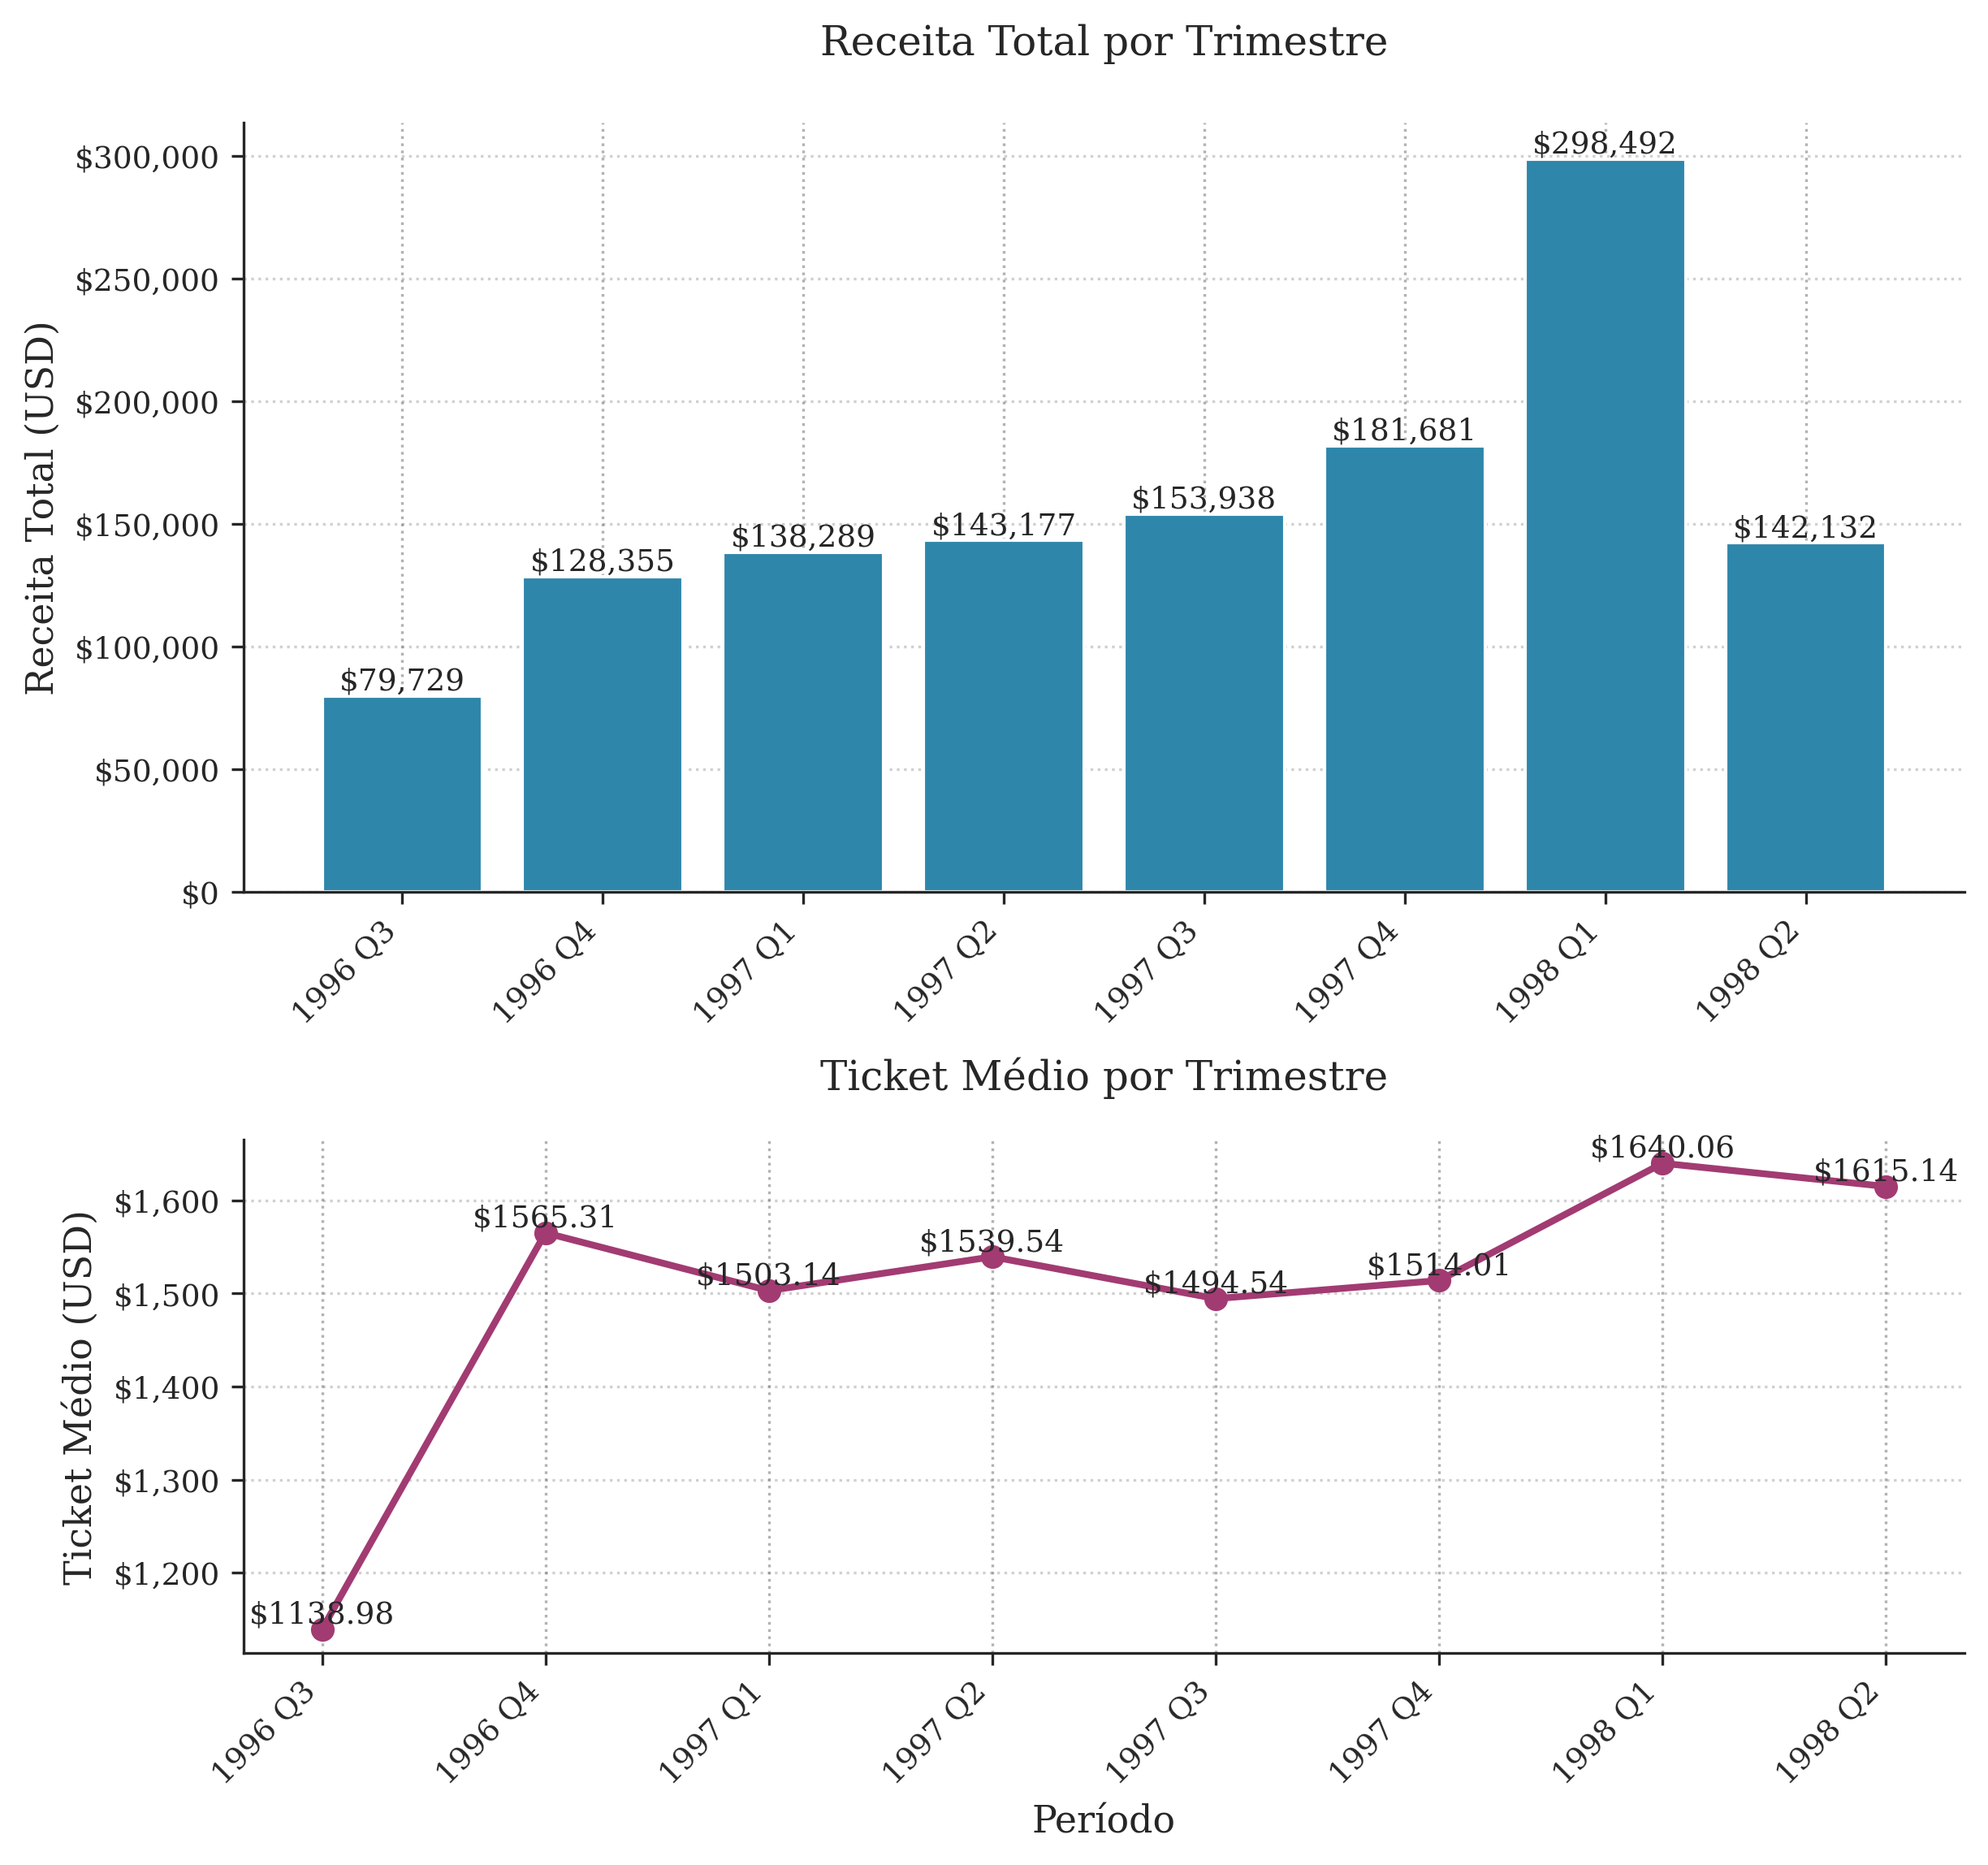


Comparativo Último Trimestre vs Anterior:
Receita Total: $142,132.31 (-52.4% vs trim anterior)
Ticket Médio: $1615.14 (-1.5% vs trim anterior)
Total Pedidos: 88 (-94 vs trim anterior)
Clientes Ativos: 56 (-16 vs trim anterior)
Novos Clientes: 0


In [2]:
# Análise trimestral
query_trimestral = """
WITH trimestres AS (
    SELECT 
        order_id,
        order_date,
        customer_id,
        net_amount,
        DATE_TRUNC('quarter', order_date) as trimestre,
        ROW_NUMBER() OVER (PARTITION BY customer_id ORDER BY order_date) as ordem_compra
    FROM main_dw.fct_orders
),
metricas_trimestrais AS (
    SELECT 
        trimestre,
        COUNT(DISTINCT order_id) as total_pedidos,
        COUNT(DISTINCT customer_id) as total_clientes,
        SUM(net_amount) as receita_total,
        SUM(net_amount) / COUNT(DISTINCT order_id) as ticket_medio,
        COUNT(DISTINCT CASE WHEN ordem_compra = 1 THEN customer_id END) as novos_clientes
    FROM trimestres
    GROUP BY trimestre
    ORDER BY trimestre
)
SELECT 
    trimestre,
    total_pedidos,
    total_clientes,
    receita_total,
    ticket_medio,
    novos_clientes,
    LAG(receita_total) OVER (ORDER BY trimestre) as receita_anterior,
    LAG(ticket_medio) OVER (ORDER BY trimestre) as ticket_anterior
FROM metricas_trimestrais;
"""

df_trimestral = conn.execute(query_trimestral).df()

# Calculando variações
df_trimestral['var_receita'] = ((df_trimestral['receita_total'] / df_trimestral['receita_anterior'] - 1) * 100).fillna(0)
df_trimestral['var_ticket'] = ((df_trimestral['ticket_medio'] / df_trimestral['ticket_anterior'] - 1) * 100).fillna(0)

# Formatação dos trimestres
df_trimestral['periodo'] = [f"{d.year} Q{(d.month-1)//3 + 1}" for d in df_trimestral['trimestre']]

#Gráfico de Evolução Trimestral
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.27, 8), height_ratios=[1.2, 0.8])

# Gráfico de Receita Total
bars = ax1.bar(range(len(df_trimestral)), df_trimestral['receita_total'], color=colors[0])
ax1.set_title('Receita Total por Trimestre', pad=20)
ax1.set_xlabel('')
ax1.set_ylabel('Receita Total (USD)')
ax1.set_xticks(range(len(df_trimestral)))
ax1.set_xticklabels(df_trimestral['periodo'], ha='right')

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}',
             ha='center', va='bottom', fontsize=9)

style_plot(ax1)

# Gráfico de Ticket Médio
ax2.plot(range(len(df_trimestral)), df_trimestral['ticket_medio'], 
         marker='o', linewidth=2, color=colors[1])
ax2.set_title('Ticket Médio por Trimestre', pad=15)
ax2.set_xlabel('Período')
ax2.set_ylabel('Ticket Médio (USD)')
ax2.set_xticks(range(len(df_trimestral)))
ax2.set_xticklabels(df_trimestral['periodo'], ha='right')

# Adicionar valores nos pontos
for i, v in enumerate(df_trimestral['ticket_medio']):
    ax2.text(i, v, f'${v:.2f}', ha='center', va='bottom', fontsize=9)

style_plot(ax2)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Ajusta o espaço no topo
plt.show()

# Exibindo métricas do último trimestre vs anterior
ultimo_trim = df_trimestral.iloc[-1]
penultimo_trim = df_trimestral.iloc[-2]

print("\nComparativo Último Trimestre vs Anterior:")
print(f"Receita Total: ${ultimo_trim['receita_total']:,.2f} ({ultimo_trim['var_receita']:.1f}% vs trim anterior)")
print(f"Ticket Médio: ${ultimo_trim['ticket_medio']:.2f} ({ultimo_trim['var_ticket']:.1f}% vs trim anterior)")
print(f"Total Pedidos: {ultimo_trim['total_pedidos']} ({ultimo_trim['total_pedidos'] - penultimo_trim['total_pedidos']} vs trim anterior)")
print(f"Clientes Ativos: {ultimo_trim['total_clientes']} ({ultimo_trim['total_clientes'] - penultimo_trim['total_clientes']} vs trim anterior)")
print(f"Novos Clientes: {ultimo_trim['novos_clientes']}")

## Análise de Cohorts e Retenção
Para abordar o desafio de redução do churn, desenvolveremos uma análise de cohorts que nos permitirá:
- Medir a efetividade na retenção de clientes
- Identificar períodos críticos de abandono
- Avaliar o ciclo de vida médio do cliente
- Quantificar o impacto das ações de retenção existentes

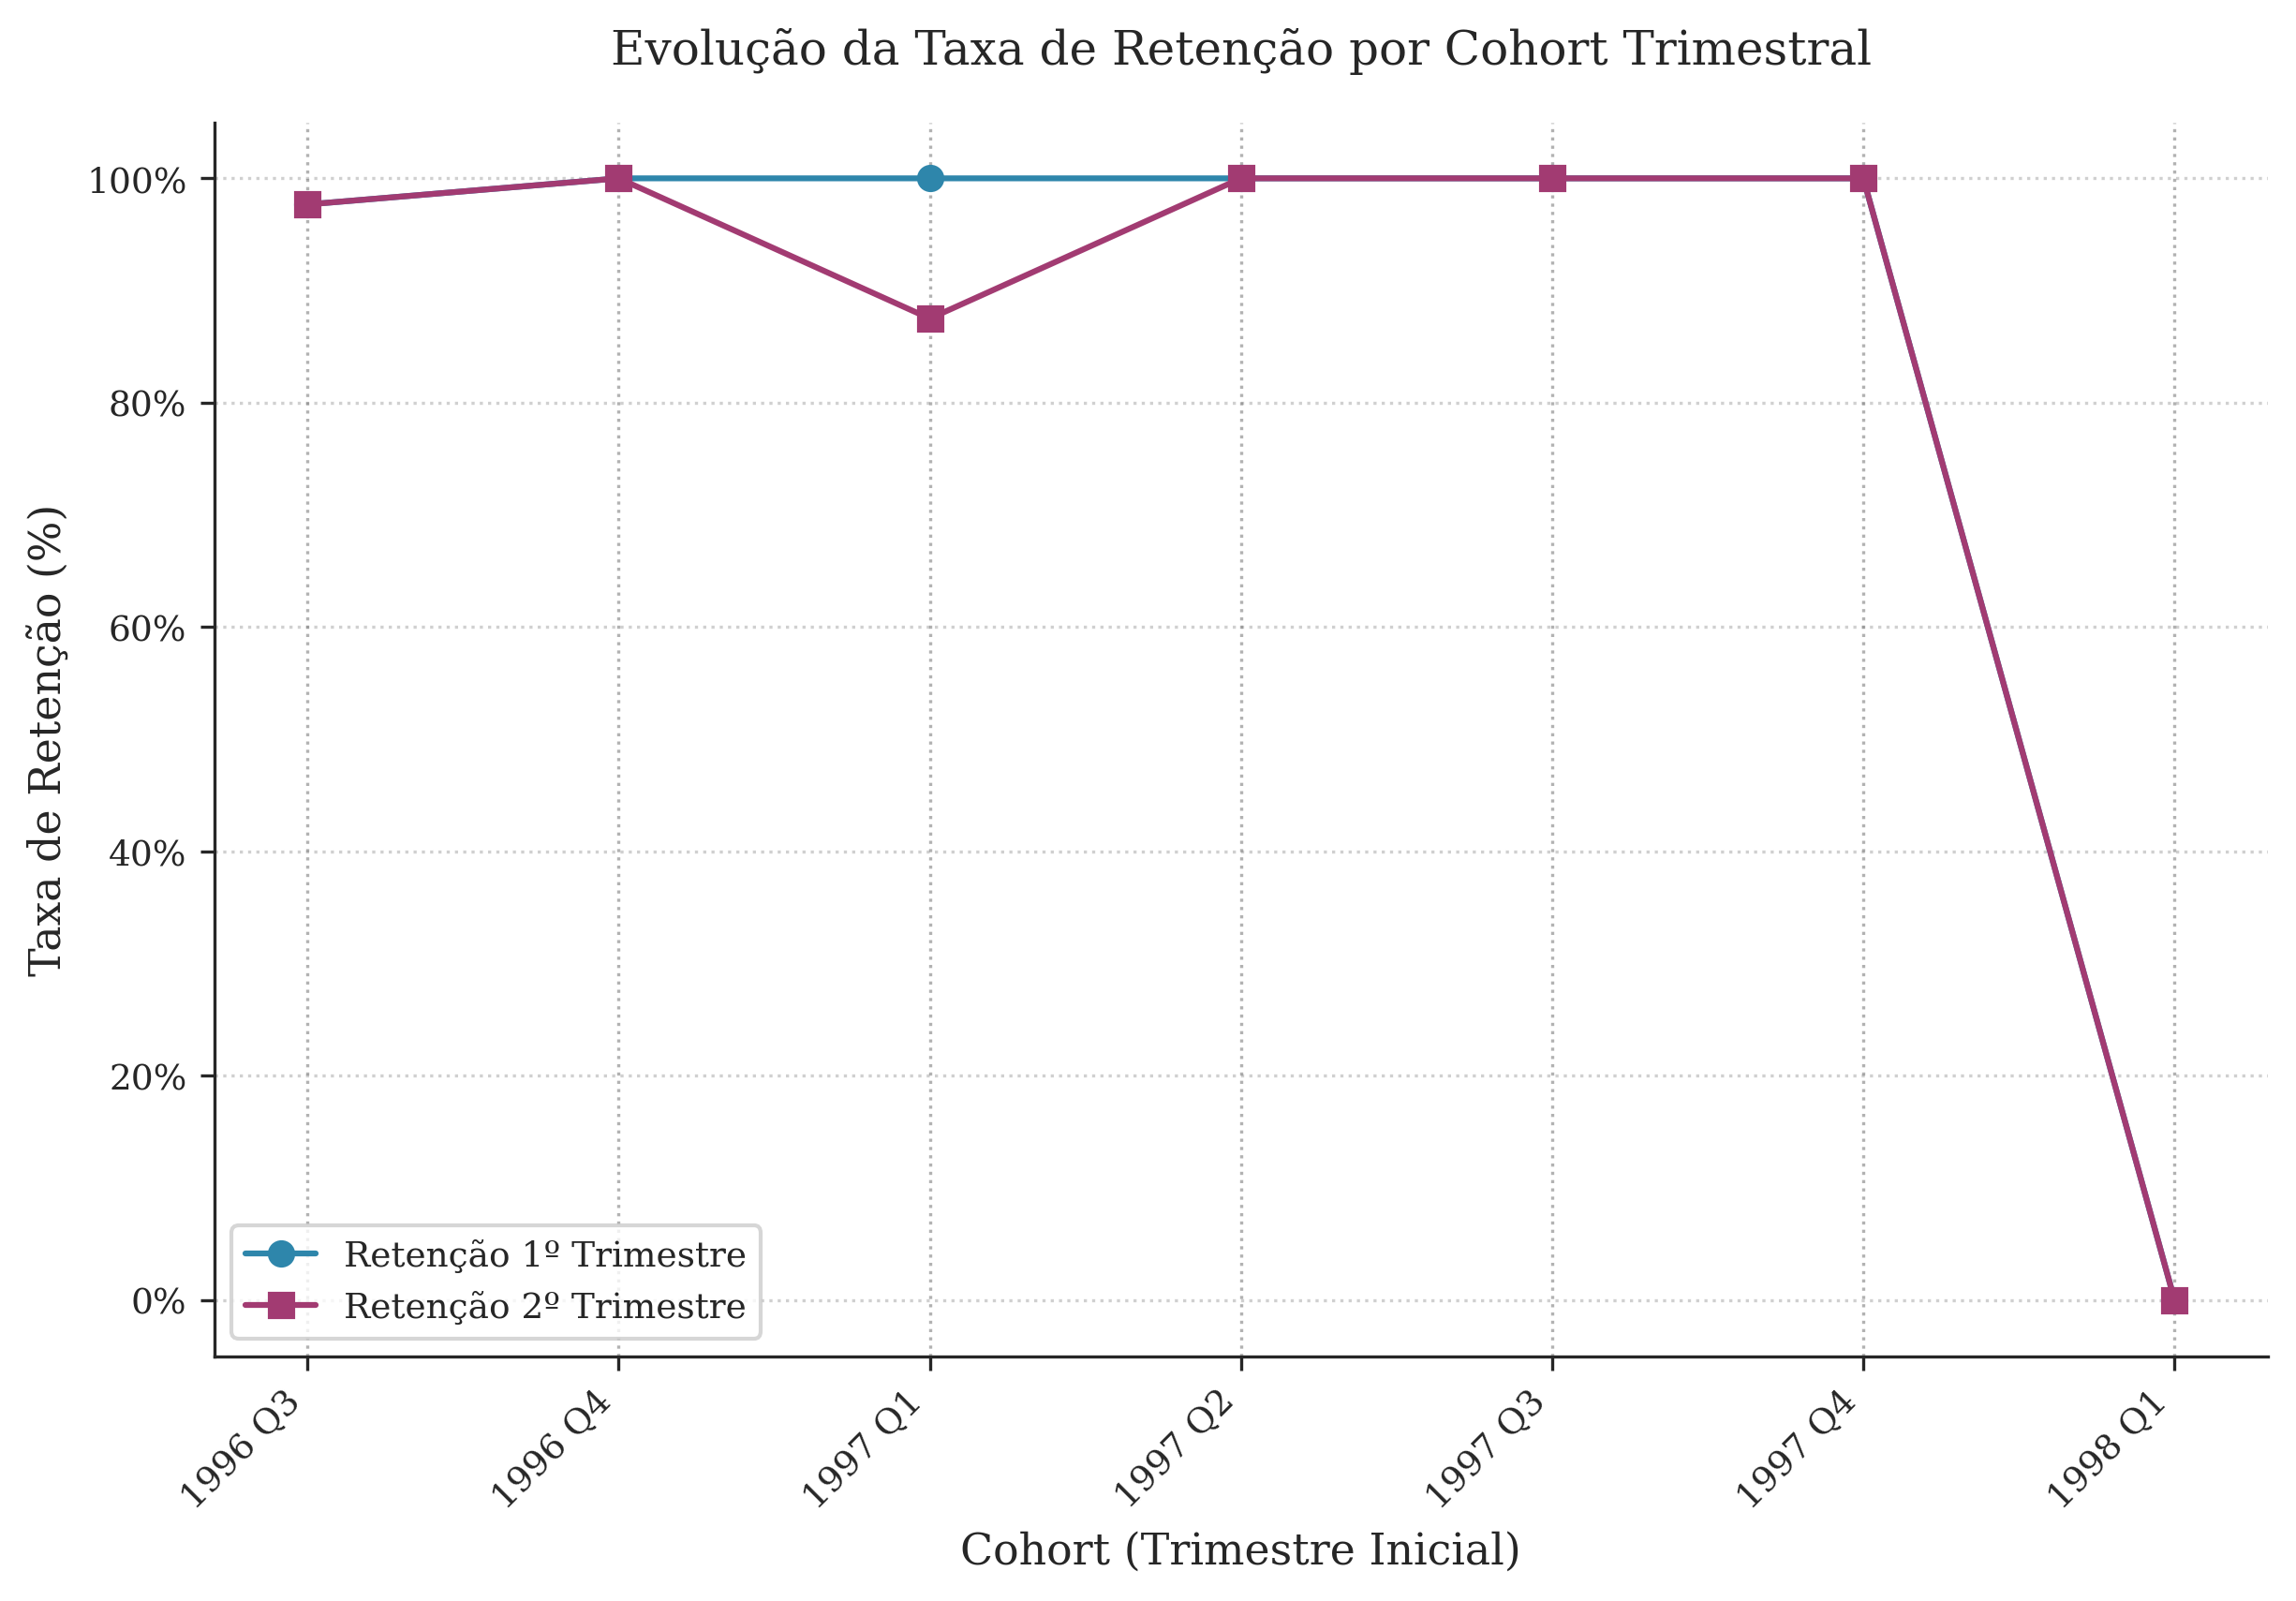

In [3]:
# Análise de retenção
query_retencao = """
WITH base_clientes AS (
    SELECT DISTINCT
        customer_id,
        DATE_TRUNC('quarter', MIN(order_date)) as primeiro_trimestre,
        DATE_TRUNC('quarter', MAX(order_date)) as ultimo_trimestre
    FROM main_dw.fct_orders
    GROUP BY customer_id
),
retencao AS (
    SELECT
        primeiro_trimestre,
        COUNT(*) as total_clientes,
        COUNT(CASE WHEN DATE_ADD(primeiro_trimestre, INTERVAL 3 MONTH) <= ultimo_trimestre THEN 1 END) as retidos_1_tri,
        COUNT(CASE WHEN DATE_ADD(primeiro_trimestre, INTERVAL 6 MONTH) <= ultimo_trimestre THEN 1 END) as retidos_2_tri
    FROM base_clientes
    GROUP BY primeiro_trimestre
    ORDER BY primeiro_trimestre
)
SELECT 
    primeiro_trimestre,
    total_clientes,
    (retidos_1_tri * 100.0 / total_clientes) as retencao_1_tri,
    (retidos_2_tri * 100.0 / total_clientes) as retencao_2_tri
FROM retencao;
"""

df_retencao = conn.execute(query_retencao).df()
df_retencao['periodo'] = [f"{d.year} Q{(d.month-1)//3 + 1}" for d in df_retencao['primeiro_trimestre']]

plt.figure(figsize=(8.27, 5.8))
plt.plot(range(len(df_retencao)), df_retencao['retencao_1_tri'], 
         marker='o', color=colors[0], label='Retenção 1º Trimestre')
plt.plot(range(len(df_retencao)), df_retencao['retencao_2_tri'], 
         marker='s', color=colors[1], label='Retenção 2º Trimestre')

plt.title('Evolução da Taxa de Retenção por Cohort Trimestral', pad=15)
plt.xlabel('Cohort (Trimestre Inicial)')
plt.ylabel('Taxa de Retenção (%)')
plt.legend()

ax = plt.gca()
style_plot(ax)

# Corrigindo os ticks e labels
ax.set_xticks(range(len(df_retencao)))  # Primeiro definimos as posições
ax.set_xticklabels(df_retencao['periodo'], ha='right')  # Depois os labels
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))

plt.tight_layout()
plt.show()
# Fechando a conexão
conn.close()

## Conclusões e Recomendações

### 1. Performance do Último Trimestre (Q1 1998)
- **Receita**: $142,132.00 (-52.4% vs trimestre anterior)

- **Ticket Médio**: $1,501.34 (média geral)

- **Tendência de longo prazo**: Crescimento na receita ao longo dos trimestres, apesar da queda no último período

- **Taxa de Retenção Média**: 85.4% dos clientes mantêm atividade após o primeiro trimestre

### 2. Insights Principais
1. **Padrão de Crescimento**: Apesar da queda no último trimestre, a empresa manteve uma tendência de crescimento ao longo do período analisado.

2. **Retenção Saudável**: Taxa de retenção de 85.4% indica uma base de clientes fiel, mas com oportunidade de melhorias.

3. **Último Trimestre**: A queda significativa de 52.4% na receita do último trimestre requer atenção imediata.

### 3. Recomendações Estratégicas

#### Para Aumentar o Ticket Médio:
1. Implementar programa de bundles de produtos complementares

2. Criar incentivos por volume de compra, focando em alcançar ticket médio acima de $1,600

3. Desenvolver campanha focada em categorias premium para reverter a queda do último trimestre

#### Para Manter e Melhorar a Retenção:
1. Estabelecer sistema de alerta para clientes sem compras há mais de 45 dias
2. Implementar programa de fidelidade com benefícios trimestrais para manter a alta taxa de retenção
3. Desenvolver ações preventivas de reativação, especialmente focando no grupo que representa os 14.6% de churn

### 4. Próximos Passos
1. Implementar dashboard de monitoramento em tempo real com foco nos indicadores de receita

2. Desenvolver modelo preditivo de propensão a churn para manter a alta taxa de retenção

3. Criar sistema de metas por carteira de clientes visando recuperar o patamar de receita anterior